# 0. Импорт сторонних библиотек

In [38]:
import time

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import itertools

import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import class_weight
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.utils import class_weight

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, classification_report, confusion_matrix

import gc

import warnings
warnings.filterwarnings('ignore')

## 0.1 Настройки Notebook и определенние глобальных переменных

In [32]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

RANDOM_SEED = 42
ROC_AUC_Treshold = 0.75

# 1. Чтение финального датасета

In [3]:
df_final = pd.read_csv('../train_data/df_final_1.csv')
df_final.head()

,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_15,pre_since_confirmed_16,pre_since_confirmed_17,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_5,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_4,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_12,pre_loans_credit_cost_rate_13,pre_loans5_1,pre_loans5_2,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_7,pre_loans5_8,pre_loans5_9,pre_loans5_11,pre_loans5_13,pre_loans5_16,pre_loans530_1,pre_loans530_2,pre_loans530_3,pre_loans530_4,pre_loans530_5,pre_loans530_6,pre_loans530_7,pre_loans530_8,pre_loans530_9,pre_loans530_10,pre_loans530_11,pre_loans530_12,pre_loans530_13,pre_loans530_14,pre_loans530_15,pre_loans530_16,pre_loans530_18,pre_loans530_19,pre_loans3060_1,pre_loans3060_2,pre_loans3060_3,pre_loans3060_4,pre_loans3060_5,pre_loans3060_6,pre_loans3060_7,pre_loans3060_8,pre_loans3060_9,pre_loans6090_1,pre_loans6090_2,pre_loans6090_3,pre_loans6090_4,pre_loans90_3,pre_loans90_8,pre_loans90_10,pre_loans90_13,pre_loans90_14,pre_loans90_19,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util

In [4]:
df_final.shape

(2750000, 358)

In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750000 entries, 0 to 2749999
Columns: 358 entries, is_zero_loans5 to target
dtypes: int64(358)
memory usage: 7.3 GB


In [13]:
df_final.target.value_counts()

target
0    2651842
1      98158
Name: count, dtype: int64

<Axes: >

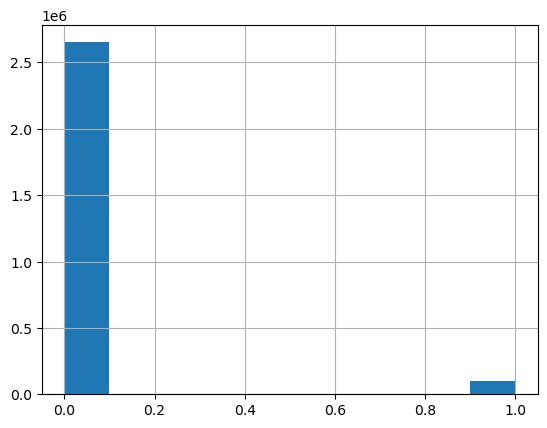

In [14]:
df_final.target.hist()

# 2. Деление датасета на тренировочную и тестовую выборки

Как видно из гистограммы распределения целевого признака, перед нами не сбалансированная выборка, отсюда следует, что деление на тренировочную и тестовую выборки следует выполнять с учетом не сбалансированности (stratify=df_final['target'])

In [5]:
df_train, df_test = train_test_split(df_final, stratify=df_final['target'], test_size=0.2, random_state=RANDOM_SEED)

X_train = df_train.drop('target', axis = 1)
y_train = df_train['target']

X_test = df_test.drop('target', axis = 1)
y_test = df_test['target']
del df_final
gc.collect()

20

# 3. Определение, тюнинг и выбор лучшей модели

In [6]:
# Функция для построения матрицы ошибок

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Поскольку выборка не сбалансирована, следует делать акцент на параметр моделей - class_weight.

In [6]:
models = []
best_score_models = {}

In [17]:
cat_boosting_model = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=7, l2_leaf_reg=9, 
                              bootstrap_type='Bayesian', loss_function='Logloss', eval_metric='AUC', 
                              auto_class_weights='Balanced', allow_writing_files=False)
models.append(cat_boosting_model)

In [18]:
gradient_boostong_model = GradientBoostingClassifier(ccp_alpha = 0.0, criterion = 'friedman_mse', loss = 'exponential', n_estimators = 500, random_state=RANDOM_SEED)
models.append(gradient_boostong_model)

In [19]:
h_gradient_boostong_model = HistGradientBoostingClassifier(loss = 'log_loss', class_weight = 'balanced',  scoring = 'roc_auc', random_state=RANDOM_SEED)
models.append(h_gradient_boostong_model)

In [20]:
log_reg_model = LogisticRegression(C = 100, multi_class = 'auto', penalty = 'l1', solver = 'saga', n_jobs=-1, class_weight = 'balanced', random_state=RANDOM_SEED)
models.append(log_reg_model)

In [21]:
random_forest_model = RandomForestClassifier(n_estimators=1000, class_weight = 'balanced', n_jobs = -1, random_state= RANDOM_SEED)
models.append(random_forest_model)

In [22]:
mlp_model = MLPClassifier(shuffle = True, early_stopping = True, random_state = RANDOM_SEED)
models.append(mlp_model)

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=8, algorithm = 'kd_tree', p = 1, weights = 'distance', n_jobs=-1)
models.append(knn_model)

In [24]:
param = {'num_leaves': 31, 'objective': 'binary', 'metric': 'auc'}
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = np.zeros_like(y_train).astype(np.float32)
weights[y_train == 0] = class_weights[0]
weights[y_train == 1] = class_weights[1]
train_data.set_weight(weights)

num_round = 1000
start_time = time.time()
lightgbm_model = lgb.train(param, train_data, num_round, valid_sets=[validation_data])
train_time = time.time() - start_time

[LightGBM] [Info] Number of positive: 78526, number of negative: 2121474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.248199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4921
[LightGBM] [Info] Number of data points in the train set: 2200000, number of used features: 351
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [25]:
y_pred_proba = lightgbm_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.6840632364909779

In [27]:
np.round(train_time, 2)

417.7

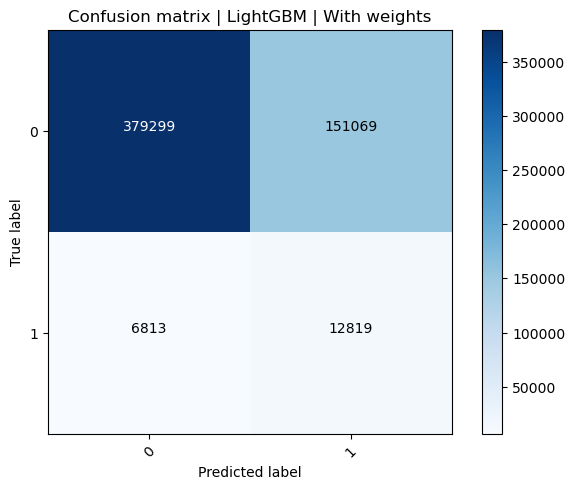

In [33]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Confusion matrix | LightGBM | With weights')

In [ ]:
for model in models:
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    pred_train = model.predict_proba(X_train)
    pred_test = model.predict_proba(X_test) 
    roc_auc_train = roc_auc_score(y_train, pred_train[:, 1])
    roc_auc_test = roc_auc_score(y_test, pred_test[:, 1])
    print(f'Модель: {type(model).__name__}\nROC_AUC на тренировочной выборке: {roc_auc_train}\nROC_AUC на тестовой выборке: {roc_auc_test}\n')
    
    if roc_auc_test >= ROC_AUC_Treshold:
        model_name = type(model).__name__
        best_score_models[f'{model_name}'] = {}
        best_score_models[f'{model_name}']['model'] = model
        best_score_models[f'{model_name}']['score'] = roc_auc_test
        best_score_models[f'{model_name}']['train_time'] = np.round(train_time, 2)
        

0:	total: 1.4s	remaining: 23m 19s
1:	total: 2.54s	remaining: 21m 8s
2:	total: 3.65s	remaining: 20m 14s
3:	total: 4.83s	remaining: 20m 1s
4:	total: 6s	remaining: 19m 55s
5:	total: 7.23s	remaining: 19m 58s
6:	total: 8.42s	remaining: 19m 54s
7:	total: 9.65s	remaining: 19m 56s
8:	total: 10.8s	remaining: 19m 53s
9:	total: 12s	remaining: 19m 46s
10:	total: 13.1s	remaining: 19m 40s
11:	total: 14.2s	remaining: 19m 32s
12:	total: 15.5s	remaining: 19m 37s
13:	total: 16.7s	remaining: 19m 32s
14:	total: 17.8s	remaining: 19m 31s
15:	total: 19s	remaining: 19m 28s
16:	total: 20.2s	remaining: 19m 28s
17:	total: 21.4s	remaining: 19m 26s
18:	total: 22.6s	remaining: 19m 24s
19:	total: 23.7s	remaining: 19m 21s
20:	total: 24.8s	remaining: 19m 17s
21:	total: 26s	remaining: 19m 16s
22:	total: 27.3s	remaining: 19m 19s
23:	total: 28.5s	remaining: 19m 20s
24:	total: 29.8s	remaining: 19m 21s
25:	total: 31s	remaining: 19m 21s
26:	total: 32.2s	remaining: 19m 20s
27:	total: 33.4s	remaining: 19m 20s
28:	total: 34.7s

223:	total: 4m 25s	remaining: 15m 18s
224:	total: 4m 26s	remaining: 15m 17s
225:	total: 4m 27s	remaining: 15m 15s
226:	total: 4m 28s	remaining: 15m 14s
227:	total: 4m 29s	remaining: 15m 13s
228:	total: 4m 30s	remaining: 15m 12s
229:	total: 4m 32s	remaining: 15m 10s
230:	total: 4m 33s	remaining: 15m 8s
231:	total: 4m 33s	remaining: 15m 6s
232:	total: 4m 35s	remaining: 15m 5s
233:	total: 4m 36s	remaining: 15m 4s
234:	total: 4m 37s	remaining: 15m 2s
235:	total: 4m 38s	remaining: 15m
236:	total: 4m 39s	remaining: 14m 59s
237:	total: 4m 40s	remaining: 14m 57s
238:	total: 4m 41s	remaining: 14m 56s
239:	total: 4m 42s	remaining: 14m 55s
240:	total: 4m 43s	remaining: 14m 54s
241:	total: 4m 45s	remaining: 14m 53s
242:	total: 4m 46s	remaining: 14m 51s
243:	total: 4m 47s	remaining: 14m 50s
244:	total: 4m 48s	remaining: 14m 49s
245:	total: 4m 49s	remaining: 14m 47s
246:	total: 4m 50s	remaining: 14m 45s
247:	total: 4m 51s	remaining: 14m 44s
248:	total: 4m 52s	remaining: 14m 43s
249:	total: 4m 54s	re

441:	total: 8m 30s	remaining: 10m 44s
442:	total: 8m 31s	remaining: 10m 42s
443:	total: 8m 32s	remaining: 10m 41s
444:	total: 8m 33s	remaining: 10m 40s
445:	total: 8m 34s	remaining: 10m 38s
446:	total: 8m 35s	remaining: 10m 37s
447:	total: 8m 36s	remaining: 10m 36s
448:	total: 8m 37s	remaining: 10m 35s
449:	total: 8m 38s	remaining: 10m 33s
450:	total: 8m 39s	remaining: 10m 32s
451:	total: 8m 40s	remaining: 10m 31s
452:	total: 8m 41s	remaining: 10m 30s
453:	total: 8m 42s	remaining: 10m 28s
454:	total: 8m 43s	remaining: 10m 27s
455:	total: 8m 44s	remaining: 10m 25s
456:	total: 8m 45s	remaining: 10m 24s
457:	total: 8m 46s	remaining: 10m 23s
458:	total: 8m 47s	remaining: 10m 21s
459:	total: 8m 48s	remaining: 10m 20s
460:	total: 8m 49s	remaining: 10m 19s
461:	total: 8m 51s	remaining: 10m 18s
462:	total: 8m 52s	remaining: 10m 17s
463:	total: 8m 53s	remaining: 10m 16s
464:	total: 8m 54s	remaining: 10m 14s
465:	total: 8m 55s	remaining: 10m 13s
466:	total: 8m 56s	remaining: 10m 12s
467:	total: 

661:	total: 12m 28s	remaining: 6m 22s
662:	total: 12m 29s	remaining: 6m 21s
663:	total: 12m 30s	remaining: 6m 19s
664:	total: 12m 31s	remaining: 6m 18s
665:	total: 12m 32s	remaining: 6m 17s
666:	total: 12m 33s	remaining: 6m 16s
667:	total: 12m 34s	remaining: 6m 15s
668:	total: 12m 35s	remaining: 6m 13s
669:	total: 12m 37s	remaining: 6m 12s
670:	total: 12m 38s	remaining: 6m 11s
671:	total: 12m 39s	remaining: 6m 10s
672:	total: 12m 40s	remaining: 6m 9s
673:	total: 12m 41s	remaining: 6m 8s
674:	total: 12m 42s	remaining: 6m 7s
675:	total: 12m 44s	remaining: 6m 6s
676:	total: 12m 45s	remaining: 6m 5s
677:	total: 12m 46s	remaining: 6m 3s
678:	total: 12m 47s	remaining: 6m 2s
679:	total: 12m 48s	remaining: 6m 1s
680:	total: 12m 49s	remaining: 6m
681:	total: 12m 50s	remaining: 5m 59s
682:	total: 12m 51s	remaining: 5m 58s
683:	total: 12m 52s	remaining: 5m 57s
684:	total: 12m 53s	remaining: 5m 55s
685:	total: 12m 54s	remaining: 5m 54s
686:	total: 12m 55s	remaining: 5m 53s
687:	total: 12m 56s	rema

880:	total: 16m 24s	remaining: 2m 13s
881:	total: 16m 25s	remaining: 2m 11s
882:	total: 16m 26s	remaining: 2m 10s
883:	total: 16m 27s	remaining: 2m 9s
884:	total: 16m 28s	remaining: 2m 8s
885:	total: 16m 30s	remaining: 2m 7s
886:	total: 16m 31s	remaining: 2m 6s
887:	total: 16m 32s	remaining: 2m 5s
888:	total: 16m 33s	remaining: 2m 4s
889:	total: 16m 34s	remaining: 2m 2s
890:	total: 16m 35s	remaining: 2m 1s
891:	total: 16m 36s	remaining: 2m
892:	total: 16m 37s	remaining: 1m 59s
893:	total: 16m 39s	remaining: 1m 58s
894:	total: 16m 40s	remaining: 1m 57s
895:	total: 16m 41s	remaining: 1m 56s
896:	total: 16m 42s	remaining: 1m 55s
897:	total: 16m 43s	remaining: 1m 54s
898:	total: 16m 44s	remaining: 1m 52s
899:	total: 16m 45s	remaining: 1m 51s
900:	total: 16m 46s	remaining: 1m 50s
901:	total: 16m 47s	remaining: 1m 49s
902:	total: 16m 48s	remaining: 1m 48s
903:	total: 16m 49s	remaining: 1m 47s
904:	total: 16m 50s	remaining: 1m 46s
905:	total: 16m 51s	remaining: 1m 44s
906:	total: 16m 52s	rema

In [33]:
best_score_models

NameError: name 'best_score_models' is not defined

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [39]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]

In [40]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                      classes=np.unique(y_train), 
                                                      y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [41]:
train_data = MyDataset(X_train.to_numpy(), y_train.to_numpy())

In [42]:
X_test_tensor = torch.from_numpy(X_test.to_numpy().astype(np.float32)).to(device)
y_test_tensor = torch.from_numpy(y_test.to_numpy().astype(np.float32)).to(device)

In [46]:
batch_size = 1024
num_epochs = 100
loss_test = []
roc_auc_test = []

loss_values = []
input_count = X_train.shape[1]

In [45]:
train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True    
)

In [47]:
class MyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super().__init__()
        
        self.hidden1 = nn.Linear(input_dim, hidden_dim_1)
        self.f1 = nn.ReLU()
        
        self.hidden2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.f2 = nn.Sigmoid()
        
        self.output = nn.Linear(hidden_dim_2, output_dim)
        self.f3 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.f2(self.hidden2(x))
        x = self.f3(self.output(x))
        return x

In [48]:
myNet = MyNet(input_count, 100, 100, 1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
myNet.to(device)
print(myNet)

MyNet(
  (hidden1): Linear(in_features=357, out_features=100, bias=True)
  (f1): ReLU()
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (f2): Sigmoid()
  (output): Linear(in_features=100, out_features=1, bias=True)
  (f3): Sigmoid()
)


In [49]:
optimizer = torch.optim.SGD(myNet.parameters(), lr=0.1)

In [50]:
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        pred = myNet(X)
        weights = torch.zeros_like(y.unsqueeze(-1))
        weights[y==0] = class_weights[0]
        weights[y==1] = class_weights[1]
        loss = F.binary_cross_entropy(pred, y.unsqueeze(-1), weight=weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [122]:
y_pred = myNet(torch.from_numpy(X_test.to_numpy().astype(np.float32)))

In [123]:
y_pred_ = [1 if i > 0.5 else 0. for i in y_pred.detach().numpy()]

In [124]:
print(f'ROC_AUC на тестовой выборке: {roc_auc_score(y_test.to_numpy().astype(np.float32), y_pred.detach().numpy())}\n')

ROC_AUC на тестовой выборке: 0.7606461967410286



In [125]:
tn = confusion_matrix(y_test, y_pred_)[0][0]
fn = confusion_matrix(y_test, y_pred_)[0][1]
tp = confusion_matrix(y_test, y_pred_)[1][1]
fp = confusion_matrix(y_test, y_pred_)[1][0]

In [126]:
tp_fp = tp / fp
tp_fp

1.7918088737201365

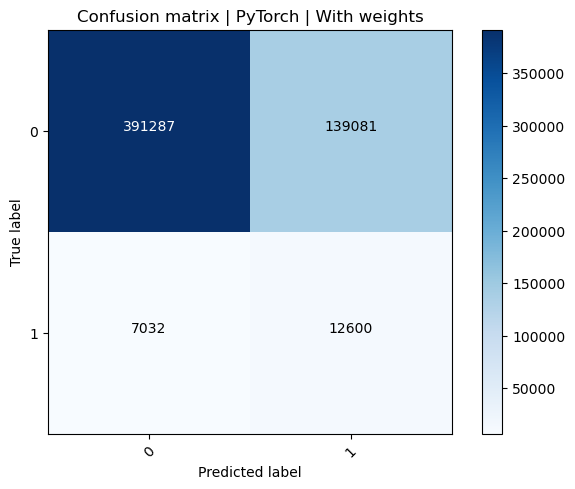

In [60]:
plot_confusion_matrix(confusion_matrix(y_test.to_numpy().astype(np.float32), y_pred_), classes=['0','1'],
                      title='Confusion matrix | PyTorch | With weights')

Наиболее удовлетворительными показателями точности ROC AUC оказались модели:

Модель: GradientBoostingClassifier
ROC_AUC на тренировочной выборке: 0.7591667320155671
ROC_AUC на тестовой выборке: 0.752547755257926

Модель: HistGradientBoostingClassifier
ROC_AUC на тренировочной выборке: 0.7634910806012487
ROC_AUC на тестовой выборке: 0.7531340232937491

Модель: MLPClassifier
ROC_AUC на тренировочной выборке: 0.7667691402528496
ROC_AUC на тестовой выборке: 0.7552824785806026

и сеть созданная на основе библиотеки PyTorch.

Ориентируюсь на метрику ROC AUC, можно сделать вывод, что все выбранные модели показали примерно одинаковый результат, удовлетворяющий условию >75%, но по скорости обучения лидирует модель на основе HistGradientBoostingClassifier.

# 4. Обучение и оценка результатов выбранной модели

Модель HistGradientBoostingClassifier показала не самую высокую предсказательную способность, но время обучения оказалось минимальным среди рассматриваемых моделей. Точность соответсвует требуемой. При изучении матрицы ошибок выяснилось, что модель HistGradientBoostingClassifier хорошо предсказывает положительный класс (факт дефолта), т.к. данный показатель критичен для нашей задачи, делаем вывод, что данная модель нам подходит.

In [ ]:
best_model = HistGradientBoostingClassifier(loss = 'log_loss', class_weight = 'balanced',  scoring = 'roc_auc', random_state=RANDOM_SEED)

In [8]:
start_time = time.time()
best_model.fit(X_train, y_train)
train_time = time.time() - start_time

NameError: name 'pred_train' is not defined

In [100]:
pred_test = best_model.predict_proba(X_test)

In [101]:
roc_auc_test = roc_auc_score(y_test, pred_test[:, 1])
print(f'Лучшая модель: {type(best_model).__name__}\nROC_AUC на тестовой выборке: {roc_auc_test}\n')

Лучшая модель: HistGradientBoostingClassifier
ROC_AUC на тестовой выборке: 0.7531340232937491



In [109]:
pred_test_ = best_model.predict(X_test)   

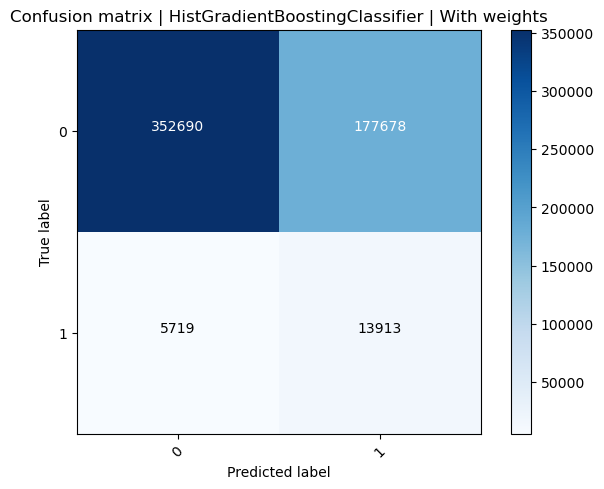

In [110]:
plot_confusion_matrix(confusion_matrix(y_test, pred_test_), classes=['0','1'],
                      title='Confusion matrix | HistGradientBoostingClassifier | With weights')

In [111]:
tn = confusion_matrix(y_test, pred_test_)[0][0]
fn = confusion_matrix(y_test, pred_test_)[0][1]
tp = confusion_matrix(y_test, pred_test_)[1][1]
fp = confusion_matrix(y_test, pred_test_)[1][0]

In [117]:
tp_fp = tp / fp
tp_fp

2.432767966427697

На один не верно предсказанный факт дефолта приходится 2,43 верно предсказанных.

Показатель метрики ROC_AUC на тестовой выборк составил 0.7531340232937491, что полностью удовлетворяет условию задачи.
Матрица ошибок показала, что соотношение верно определенных клиентов которые склонны к дефолту - 2,43

# 5. Сохранение обученной модели в файл

In [20]:
with open('best_model.pickle', 'wb') as file:
    pickle.dump(best_model, file)